In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

sns.set_style('whitegrid')
np.random.seed(42)
results_path = Path('results', 'cifar10')
if not results_path.exists():
    results_path.mkdir()

Using GPU


In [3]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [37]:
X_train.shape, y_train.shape

((45000, 32, 32, 3), (45000, 1))

In [4]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
num_classes = len(cifar10_labels)
height, width, channels = X_train.shape[1:]
input_shape = height, width, channels
input_shape

(32, 32, 3)

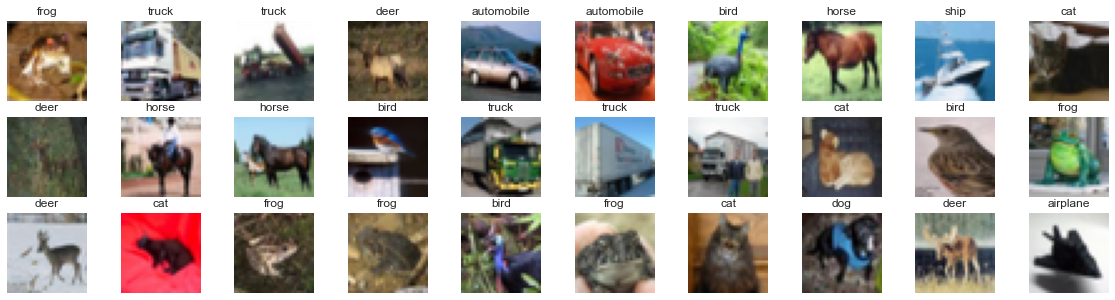

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')
    ax.set_title(cifar10_labels[y_train[i, 0]])

In [6]:
# Rescale the Images
X_train = X_train.astype('float32') / 255 # rescale [0,255] --> [0,1]
X_test = X_test.astype('float32') / 255

# Train-Test split
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

X_train.shape # shape of training set

(45000, 32, 32, 3)

In [7]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


In [8]:
# Feedforward Neural Network
mlp = Sequential([
    Flatten(input_shape=input_shape, name='input'),
    Dense(1000, activation='relu', name='hidden_layer_1'),
    Dropout(0.2, name='droput_1'),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 hidden_layer_1 (Dense)      (None, 1000)              3073000   
                                                                 
 droput_1 (Dropout)          (None, 1000)              0         
                                                                 
 hidden_layer_2 (Dense)      (None, 512)               512512    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 3,590,642
Trainable params: 3,590,642
Non-

In [9]:
mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Callbacks
mlp_path = (results_path / 'mlp.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=mlp_path, verbose=1, monitor='val_accuracy', save_best_only=True)
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'mlp', histogram_freq=1, write_graph=True,
                          write_grads=False, update_freq='epoch')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [10]:
# Train the Model
batch_size = 32
epochs = 100
mlp_history = mlp.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_valid, y_valid), workers=6,
                      callbacks=[checkpointer, tensorboard, early_stopping], verbose=1, shuffle=True)

Epoch 1/100
1392/1407 [============================>.] - ETA: 0s - loss: 2.0000 - accuracy: 0.2655
Epoch 00001: val_accuracy improved from -inf to 0.34460, saving model to results/cifar10\mlp.weights.best.hdf5
1407/1407 [==============================] - 7s 4ms/step - loss: 1.9990 - accuracy: 0.2659 - val_loss: 1.8092 - val_accuracy: 0.3446
Epoch 2/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.8698 - accuracy: 0.3121
Epoch 00002: val_accuracy improved from 0.34460 to 0.36880, saving model to results/cifar10\mlp.weights.best.hdf5
1407/1407 [==============================] - 5s 3ms/step - loss: 1.8697 - accuracy: 0.3120 - val_loss: 1.7635 - val_accuracy: 0.3688
Epoch 3/100
1389/1407 [============================>.] - ETA: 0s - loss: 1.8325 - accuracy: 0.3268
Epoch 00003: val_accuracy did not improve from 0.36880
1407/1407 [==============================] - 4s 3ms/step - loss: 1.8325 - accuracy: 0.3270 - val_loss: 1.7861 - val_accuracy: 0.3520
Epoch 4/100
1395/1407 [=

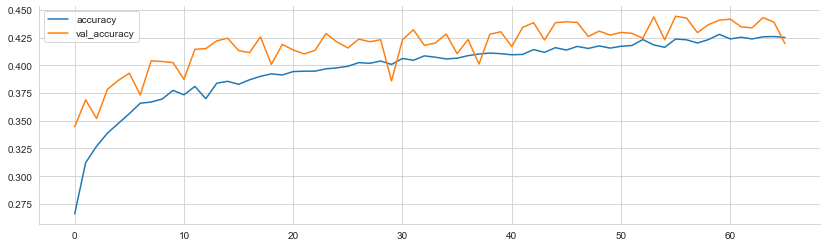

In [11]:
# Plot CV Results
pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 4))
sns.despine()

In [45]:
# Load best model
mlp.load_weights(mlp_path) # load the weights that yielded the best validation accuracy

# Test Classification Accuracy
mlp_accuracy = mlp.evaluate(X_test, y_test, verbose=0)[1]
print(f'Feedforward Neural Network Test accuracy: {mlp_accuracy:.2%}')

Feedforward Neural Network Test accuracy: 44.30%


In [13]:
# Convolutional Neural Network
# https://stackoverflow.com/questions/35114376/error-when-computing-summaries-in-tensorflow/35117760#35117760
K.clear_session()

# Model Architecture
cnn = Sequential([Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=input_shape,
           name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
    Dense(10, activation='softmax', name='FC2')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 32, 32, 16)        208       
                                                                 
 POOL1 (MaxPooling2D)        (None, 16, 16, 16)        0         
                                                                 
 CONV2 (Conv2D)              (None, 16, 16, 32)        2080      
                                                                 
 POOL2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 CONV3 (Conv2D)              (None, 8, 8, 64)          8256      
                                                                 
 POOL3 (MaxPooling2D)        (None, 4, 4, 64)          0         
                                                                 
 DROP1 (Dropout)             (None, 4, 4, 64)          0

In [14]:
# Compile the Model
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Callbacks
cnn_path = (results_path / 'cnn.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=cnn_path, verbose=1, monitor='val_accuracy', save_best_only=True)
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn', histogram_freq=1, write_graph=True,
                          write_grads=False, update_freq='epoch')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [15]:
# Train the Model
batch_size = 32
epochs = 100
cnn_history = cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=2, shuffle=True, workers=6)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.58380, saving model to results/cifar10\cnn.weights.best.hdf5
1407/1407 - 10s - loss: 1.5330 - accuracy: 0.4431 - val_loss: 1.2049 - val_accuracy: 0.5838 - 10s/epoch - 7ms/step
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.58380 to 0.62760, saving model to results/cifar10\cnn.weights.best.hdf5
1407/1407 - 5s - loss: 1.1954 - accuracy: 0.5716 - val_loss: 1.0527 - val_accuracy: 0.6276 - 5s/epoch - 4ms/step
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.62760 to 0.66340, saving model to results/cifar10\cnn.weights.best.hdf5
1407/1407 - 5s - loss: 1.0780 - accuracy: 0.6156 - val_loss: 0.9561 - val_accuracy: 0.6634 - 5s/epoch - 4ms/step
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.66340 to 0.68460, saving model to results/cifar10\cnn.weights.best.hdf5
1407/1407 - 6s - loss: 0.9926 - accuracy: 0.6478 - val_loss: 0.9073 - val_accuracy: 0.6846 - 6s/epoch - 4ms/step
Epoch 5/100

Epoch 00005: val_accuracy im

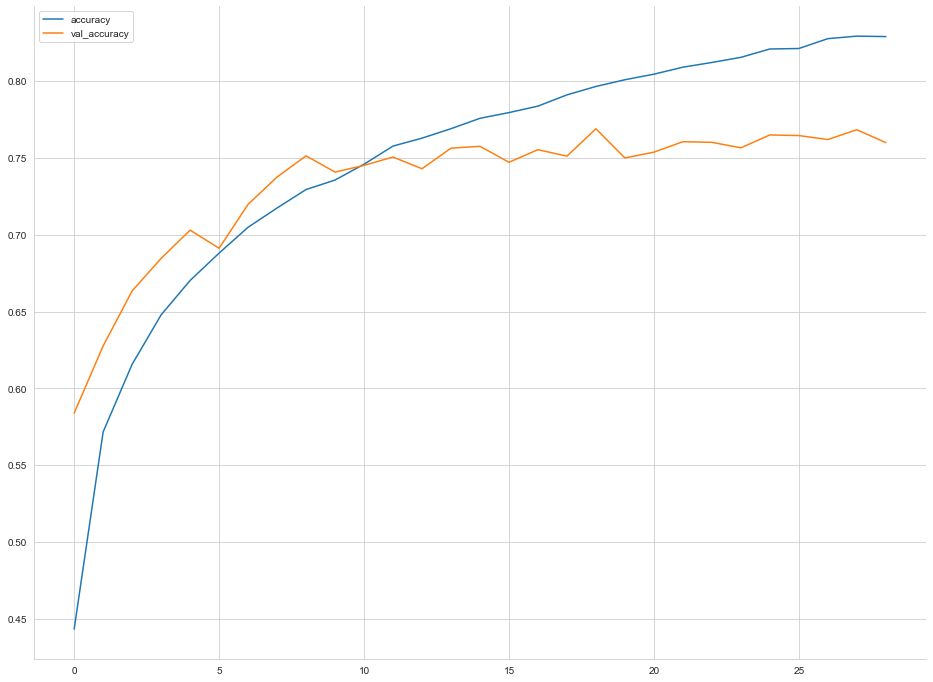

In [16]:
# Plot CV Results
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(16, 12))
sns.despine();

In [44]:
# Load best model
cnn.load_weights(cnn_path)

# Test set accuracy
cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('CNN Accuracy: {:.2%}'.format(cnn_accuracy))

CNN Accuracy: 75.37%


D:\99.Dev\Python\pythonProject\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  func(*args, **kwargs)
D:\99.Dev\Python\pythonProject\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


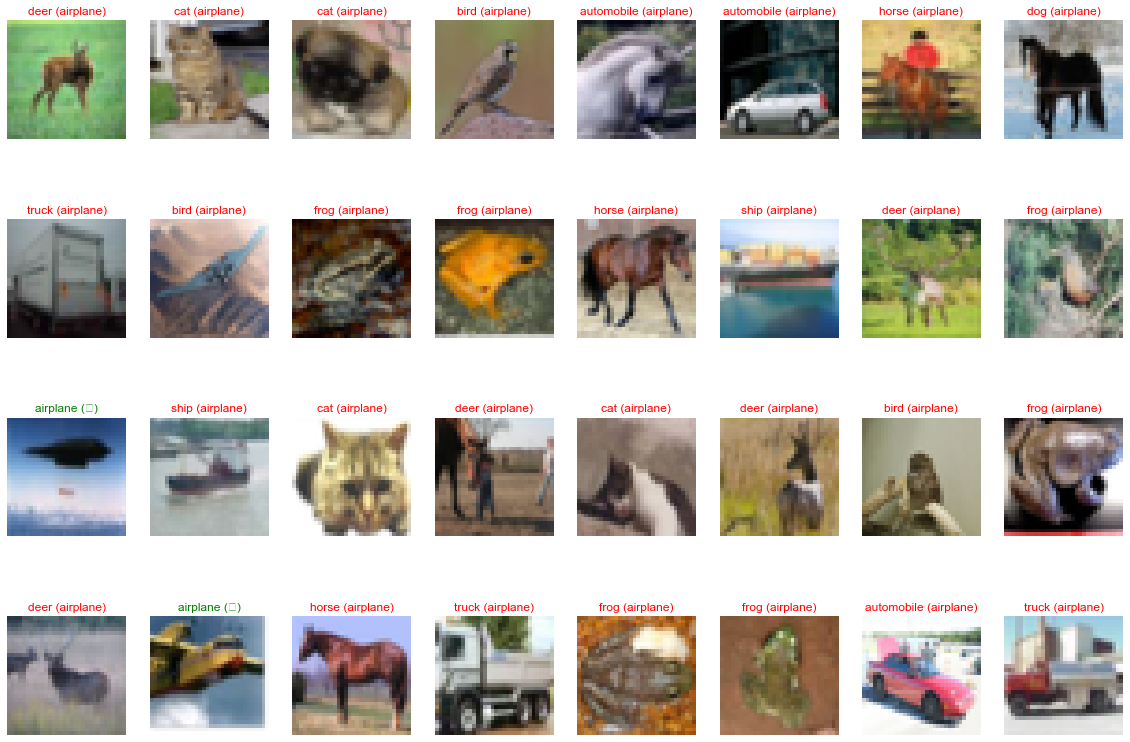

In [35]:
# Evaluate Predictions
y_hat = cnn.predict(X_test)
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 14))
axes = axes.flatten()
images = np.random.choice(X_test.shape[0], size=32, replace=False)
for i, (ax, idx) in enumerate(zip(axes, images)):
    ax.imshow(np.squeeze(X_test[idx]))
    ax.axis('off')
    pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx])
    if pred_idx == true_idx:
        ax.set_title('{} (✓)'.format(cifar10_labels[pred_idx]), color="green")
    else:
        ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]), color='red')

In [19]:
# Create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly horizontal shift
    height_shift_range=0.1,  # randomly vertial shift
    horizontal_flip=True)  # randomly horizontalflip

# fit augmented image generator on data
datagen.fit(X_train)

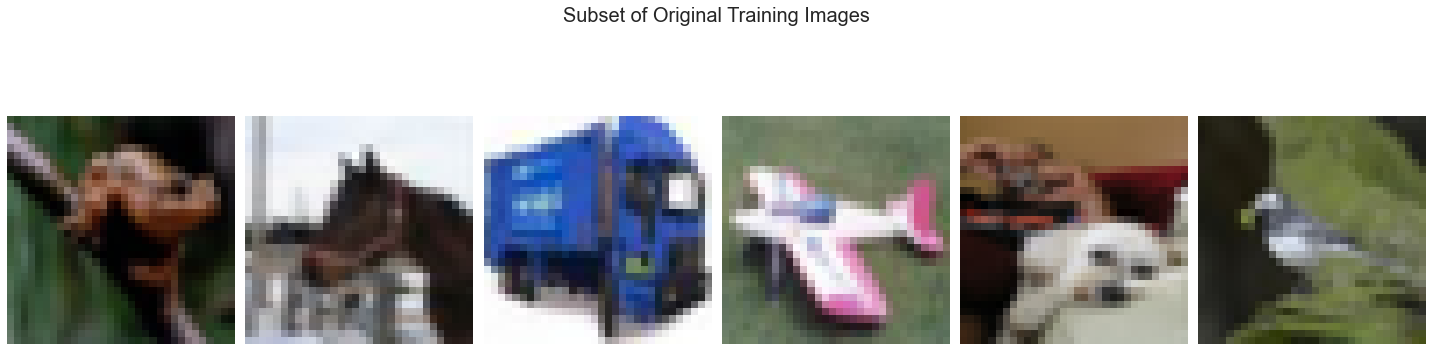

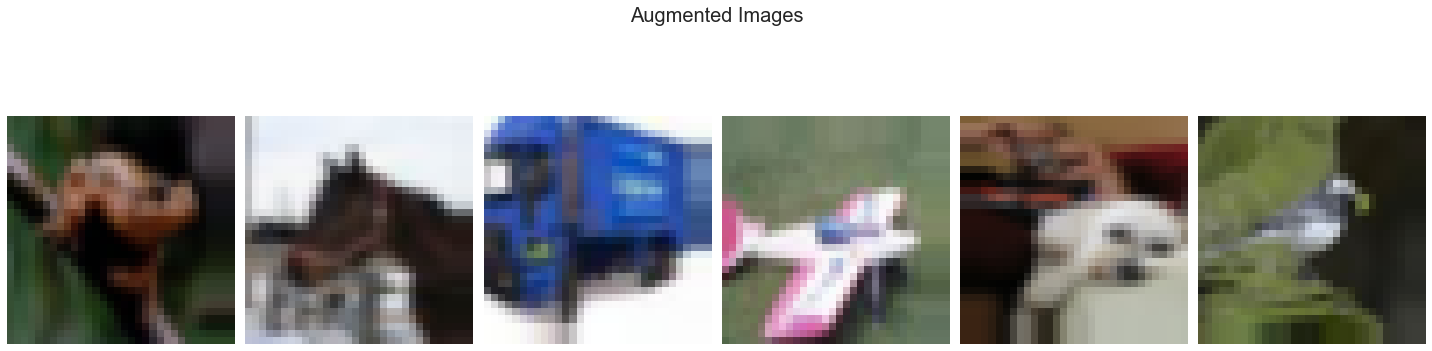

In [34]:
# Visualize subset of training data
n_images = 6
x_train_subset = X_train[:n_images]

# original images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 6))
for i, (ax, img) in enumerate(zip(axes, x_train_subset)):
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Subset of Original Training Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'original_images')

# augmented images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 6))
for x_batch in datagen.flow(x_train_subset, batch_size=n_images, shuffle=False):
    for i, ax in enumerate(axes):
        ax.imshow(x_batch[i])
        ax.axis('off')
#     fig.suptitle('Augmented Images', fontsize=20)
    break
fig.suptitle('Augmented Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'augmented_images')

In [21]:
# Define Callbacks
K.clear_session()

cnn_aug_path = (results_path / 'augmented.cnn.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=cnn_aug_path, verbose=1, monitor='val_accuracy', save_best_only=True)
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn_aug', histogram_freq=1, write_graph=True,
                          write_grads=False, update_freq='epoch')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [22]:
# Train Augmented Images
batch_size = 32
epochs = 100
cnn_aug_history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          steps_per_epoch=X_train.shape[0] // batch_size,
                          epochs=epochs, validation_data=(X_valid, y_valid),
                          callbacks=[checkpointer, tensorboard, early_stopping],
                          verbose=2, workers=6)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.73800, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
1406/1406 - 12s - loss: 0.9525 - accuracy: 0.6688 - val_loss: 0.7605 - val_accuracy: 0.7380 - 12s/epoch - 9ms/step
Epoch 2/100

Epoch 00002: val_accuracy did not improve from 0.73800
1406/1406 - 12s - loss: 0.9158 - accuracy: 0.6784 - val_loss: 0.7823 - val_accuracy: 0.7350 - 12s/epoch - 9ms/step
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.73800 to 0.73900, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
1406/1406 - 12s - loss: 0.9025 - accuracy: 0.6823 - val_loss: 0.7525 - val_accuracy: 0.7390 - 12s/epoch - 8ms/step
Epoch 4/100

Epoch 00004: val_accuracy did not improve from 0.73900
1406/1406 - 12s - loss: 0.8905 - accuracy: 0.6884 - val_loss: 0.7661 - val_accuracy: 0.7372 - 12s/epoch - 9ms/step
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.73900 to 0.74820, saving model to results/cifar10\augmented.cnn.weights.best.h

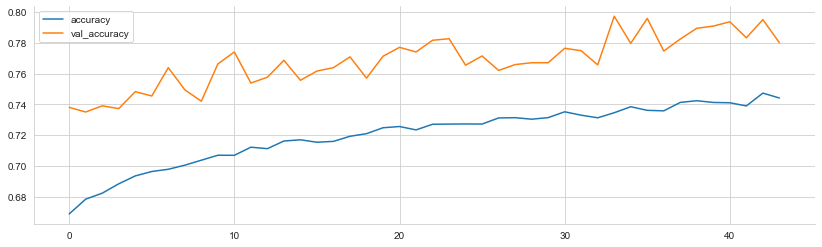

In [23]:
# Plot CV Result
pd.DataFrame(cnn_aug_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 4))
sns.despine();

In [43]:
# Load best model
cnn.load_weights(cnn_aug_path)

cnn_aug_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('CNN Augmented Test Accuracy: {:.2%}'.format(cnn_aug_accuracy))

CNN Augmented Test Accuracy: 78.50%


In [25]:
# AlexNet
K.clear_session()

alexnet = Sequential([
    # 1st Convolutional Layer
    Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same',
           input_shape=input_shape, name='CONV_1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL_1'),
    BatchNormalization(name='NORM_1'),

    # 2nd Convolutional Layer
    Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', name='CONV2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL2'),
    BatchNormalization(name='NORM_2'),

    # 3rd Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', name='CONV3'),

    # 4th Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', name='CONV4'),

    # 5th Convolutional Layer
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='CONV5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL5'),
    BatchNormalization(name='NORM_5'),

    # Fully Connected Layers
    Flatten(name='FLAT'),
    Dense(4096, input_shape=(32 * 32 * 3, ), activation='relu', name='FC1'),
    Dropout(0.4, name='DROP1'),
    Dense(4096, activation='relu', name='FC2'),
    Dropout(0.4, name='DROP2'),
    Dense(num_classes, activation='softmax')
])
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV_1 (Conv2D)             (None, 16, 16, 96)        2688      
                                                                 
 POOL_1 (MaxPooling2D)       (None, 8, 8, 96)          0         
                                                                 
 NORM_1 (BatchNormalization)  (None, 8, 8, 96)         384       
                                                                 
 CONV2 (Conv2D)              (None, 8, 8, 256)         614656    
                                                                 
 POOL2 (MaxPooling2D)        (None, 3, 3, 256)         0         
                                                                 
 NORM_2 (BatchNormalization)  (None, 3, 3, 256)        1024      
                                                                 
 CONV3 (Conv2D)              (None, 3, 3, 384)         8

In [26]:
# Compile Model
alexnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Callbacks
alexnet_path = (results_path / 'alexnet.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=alexnet_path, verbose=1, monitor='val_accuracy', save_best_only=True)
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'alexnet', histogram_freq=1, write_graph=True,
                          write_grads=False, update_freq='epoch')
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

In [27]:
# Train Model
batch_size = 32
epochs = 100
alex_history = alexnet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                           validation_data=(X_valid, y_valid),
                           callbacks=[checkpointer, tensorboard, early_stopping],
                           verbose=1, workers=6)

Epoch 1/100
1407/1407 [==============================] - ETA: 0s - loss: 1.5933 - accuracy: 0.4357
Epoch 00001: val_accuracy improved from -inf to 0.40340, saving model to results/cifar10\alexnet.weights.best.hdf5
1407/1407 [==============================] - 35s 24ms/step - loss: 1.5933 - accuracy: 0.4357 - val_loss: 1.6425 - val_accuracy: 0.4034
Epoch 2/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.2955 - accuracy: 0.5487
Epoch 00002: val_accuracy improved from 0.40340 to 0.52920, saving model to results/cifar10\alexnet.weights.best.hdf5
1407/1407 [==============================] - 24s 17ms/step - loss: 1.2957 - accuracy: 0.5487 - val_loss: 1.5205 - val_accuracy: 0.5292
Epoch 3/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.0430 - accuracy: 0.6396
Epoch 00003: val_accuracy improved from 0.52920 to 0.61920, saving model to results/cifar10\alexnet.weights.best.hdf5
1407/1407 [==============================] - 24s 17ms/step - loss: 1.0431 - accura

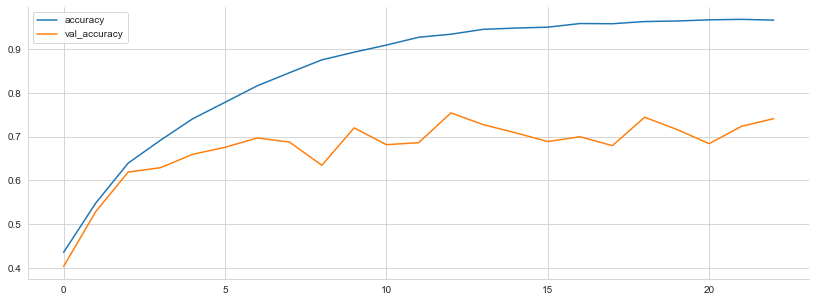

In [28]:
pd.DataFrame(alex_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 5))
sns.despine()

In [29]:
alexnet.load_weights(alexnet_path)

In [42]:
alex_accuracy = alexnet.evaluate(X_test, y_test, verbose=0)[1]
print('Alexnet Test Accuracy: {:.2%}'.format(alex_accuracy))

Alexnet Test Accuracy: 73.72%


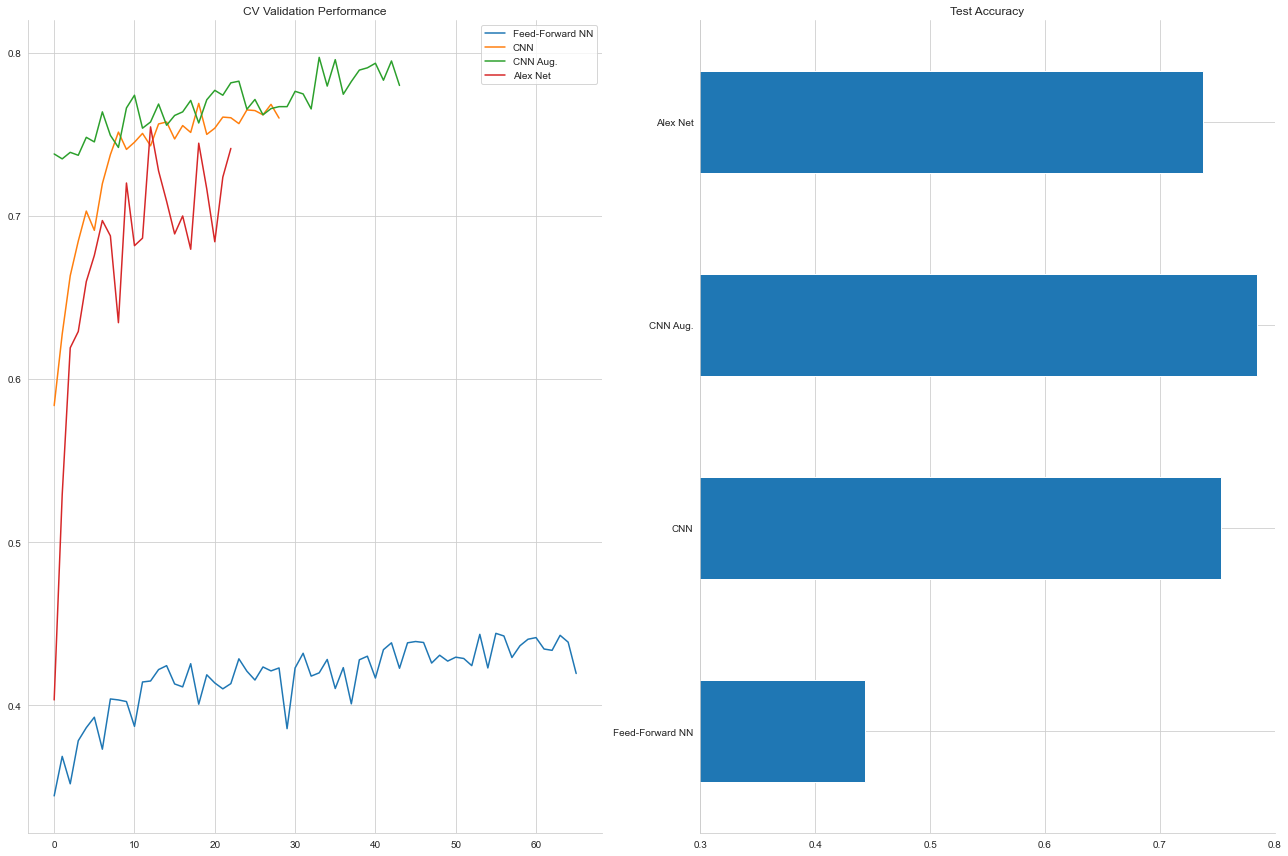

In [31]:
# Compare Results
cv_results = pd.DataFrame(
    {'Feed-Forward NN': pd.Series(mlp_history.history['val_accuracy']),
    'CNN': pd.Series(cnn_history.history['val_accuracy']),
    'CNN Aug.': pd.Series(cnn_aug_history.history['val_accuracy']),
    'Alex Net': pd.Series(alex_history.history['val_accuracy'])})

test_accuracy = pd.Series({
    'Feed-Forward NN': mlp_accuracy,
    'CNN': cnn_accuracy,
    'CNN Aug.': cnn_aug_accuracy,
    'Alex Net': alex_accuracy})

fig, axes = plt.subplots(ncols=2, figsize=(18, 12))
cv_results.plot(ax=axes[0], title='CV Validation Performance')
test_accuracy.plot.barh(ax=axes[1], xlim=(.3, .8), title='Test Accuracy')
fig.tight_layout()
sns.despine()
fig.savefig(results_path / 'comparison', dpi=300);

In [32]:
# TensorBoard visualization
%load_ext tensorboard
%tensorboard --logdir results/cifar10/logs

Launching TensorBoard...